In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score,
                             roc_auc_score)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import xgboost as xgb

warnings.filterwarnings('ignore')

In [2]:
# Load and sample data
df = pd.read_feather("/content/drive/MyDrive/home_assignment.feather").sample(frac=0.4)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## **Data Preparation**

### **EDA**

Let's look at the target variable

In [3]:
# Count the number of values greater than x
count_greater_than_x = (df['TLJYWBE'] > 1e-5).sum()

# Count the number of values less than x
count_less_than_x = (df['TLJYWBE'] < 1e-5).sum()

# Count the number of values that are NaN
count_na = df['TLJYWBE'].isna().sum()

print(f"Count of values greater than {1e-5}: {count_greater_than_x}")
print(f"Count of values less than {1e-5}: {count_less_than_x}")
print(f"Count of nan {1e-5}: {count_na}")

Count of values greater than 1e-05: 19
Count of values less than 1e-05: 283786
Count of nan 1e-05: 6710


**Create a data report to see the distributions, dtypes and more**

In [ ]:
from ydata_profiling import ProfileReport

# Create a ProfileReport
profile = ProfileReport(df_filtered.sample(frac = 0.1), title="Pandas Profiling Report", minimal=True)

# Save the report to an HTML file
profile.to_file("EDA.html")

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### **Data Manipulation**

**Try to reduce number of columns - first let's remove columns where we think the model won't learn to much from (e.g where most data is null or constant value)**

In [4]:
# Identify columns where NaN/nulls makes up more than 70% of the data
null_dominated_columns = [col for col in df.columns if df[col].isna().mean() > 0.70]
nan_dominated_columns = [col for col in df.columns if df[col].isnull().mean() > 0.70]

# Identify columns where 0 makes up more than 70% of the data
zero_dominated_columns = [col for col in df.columns if (df[col] == 0).mean() > 0.70]

# Identify columns with 1 dominate value
value_dominated_columns = [col for col in df.columns if df[col].value_counts(normalize=True).max() > 0.9]

columns_to_drop = list(set(value_dominated_columns + zero_dominated_columns + nan_dominated_columns))

# Drop these columns from the DataFrame
df_filtered = df.drop(columns=columns_to_drop)

# Display the columns that were dropped
print(f"Columns with constant values or dominated by zeros: {columns_to_drop}")
print(f"Original shape: {df.shape}")
print(f"Reduced shape: {df_filtered.shape}")

Columns with constant values or dominated by zeros: ['CYGFXWC', 'DLWYUSK', 'HLUJJDC', 'SHAHZCX', 'VRXSNDL', 'YEZPLBM', 'HFHITLP', 'ZMOCACF', 'ZAIRSDG', 'SWMNPFK', 'OELFGBD', 'KVNLYTZ', 'FRICEIH', 'KDIATNL', 'MRDZBFN', 'IJTGMGJ', 'PBZEGCA', 'XUCVAEV', 'FJXWXPI', 'OELGKKQ', 'BKAHOMJ', 'UGFBHFI', 'NMCAKWK', 'TQSLCKT', 'JWJHZJJ', 'THFGWMH', 'FJCYMJD', 'PKCUSYS', 'EYAUITY', 'HOAJWUR', 'KCVNCWE', 'VUBFVUN', 'FRPZZAO', 'TNLTITB', 'FYWFJXP', 'PTGZANY', 'EJLLSVL', 'WTARSLQ', 'EBEXNTO', 'RHCAZIU', 'RQTEIMY', 'QNIBUZZ', 'IPLONQP', 'MAODOCR', 'WHWNSMK', 'NOIYREE', 'ALVJYOA', 'AQYGYOE', 'NMWUWJL', 'UBMPCGB', 'XQJKMDS', 'SHLZRCB', 'XXIPGDP', 'HTMOHRO', 'KKKSVYN', 'AHMUWMD', 'BTEYMSX', 'CJICMVV', 'WSTYRNH', 'MPRIFAX', 'LEVGOPF', 'DRELDXX', 'ADOIOYN', 'MKGQLST', 'IMAZODZ', 'CPZMPBY', 'ZSCIZXU', 'WSRRROM', 'FSBLFRV', 'LNZGNNA', 'TDMCRGU', 'JYNEQWD', 'MUEKGHC', 'FIGZKCY', 'LYCIQTI', 'WCYWJXK', 'RGDZIYI', 'SHEGNUT', 'YPMGCVT', 'BBMREOD', 'GJFZDWF', 'XZSIRUV', 'OPYOPFC', 'MZUTRGY', 'AUNDDNZ', 'BXBUVRU', '

**Transform all columns to numerical dtype (as they are all numerical but pd detected them as 'object' due to nans)**

In [6]:
# True/False values will become 1/0
df_filtered = df_filtered.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Object types will transform to numerical types
df_filtered = df_filtered.apply(pd.to_numeric, errors='coerce')

**I want to check the columns I removed and if they are corr witht he target variable - is so, I will reinstate those who are highly correleted**

In [ ]:
# Recheck correlations
dropped_columns_df = df[columns_to_drop]
correlations = dropped_columns_df.corrwith(df['TLJYWBE'])

# filter only correlations above a certain threshold (e.g., |0.1|)
significant_correlations = correlations[abs(correlations) > 0.1]

print("Columns with significant correlation with the outcome:")
print(significant_correlations)

**I found that  *'LNZGNNA'*, *'YTYOTNN'* and *'KWGZVQN'* are corr with the target variable so I decide to include them back: the model might pick on the relashionship to make better predictions**

In [5]:
# Reinclude significant columns
exclude_columns = ['LNZGNNA', 'YTYOTNN', 'KWGZVQN']
columns_to_drop = [col for col in columns_to_drop if col not in exclude_columns]
df_filtered = df.drop(columns=columns_to_drop)
print(f"Columns retained: {exclude_columns}")
print(f"Original shape: {df.shape}")
print(f"Reduced shape: {df_filtered.shape}")

Columns retained: ['LNZGNNA', 'YTYOTNN', 'KWGZVQN']
Original shape: (290515, 881)
Reduced shape: (290515, 649)


**Next step to reduce number of columns is to removed highly correleted columnes (I have set a threshold of 0.9) - the idea is that if we have 2 corr columns then one is enought the learn from, and most likly the other won't share new information to the model.**

In [7]:
del(df)

In [8]:
# I use a sample of the numeric data for correlation matrix due to memory issues
correlation_matrix = df_filtered.sample(frac=0.5).corr()

# I set a high threshold for correlation to be cautious
threshold = 0.9

# Identify feature pairs with correlation higher than the threshold
high_correlation = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix != 1.0)]

# Find the column pairs
correlated_features = high_correlation.stack().reset_index()
correlated_features.columns = ['Feature1', 'Feature2', 'Correlation']

columns_to_drop = set()

# Iterate over the pairs and add one of the highly correlated columns to the drop list
for feature1, feature2, _ in correlated_features.values:
    columns_to_drop.add(feature2)

columns_to_drop = list(columns_to_drop)

# Drop the highly correlated columns from the DataFrame
df_reduced = df_filtered.drop(columns=columns_to_drop)

print(f"Columns dropped due to high correlation: {columns_to_drop}")
print(f"Original shape: {df_filtered.shape}")
print(f"Reduced shape: {df_reduced.shape}")

Columns dropped due to high correlation: ['UHMRZHI', 'RLWEKLY', 'XQGPAIG', 'QVSCEFJ', 'XNHNHIK', 'ULYIQYO', 'NTJRVGR', 'EULURHL', 'NRZNVUW', 'JORKKSF', 'EJMEHVK', 'YLHQTEA', 'UILLRWJ', 'WIWNVTH', 'LGVRVXB', 'JMPVBOV', 'SLHDFLB', 'RHSKKTW', 'XMVIFQS', 'TPYJDFW', 'UJYQCMY', 'NOLZTQY', 'UGXVMKE', 'SBUETBP', 'FAIOOOV', 'GYFZSXY', 'LTZYUVU', 'AWMGPPL', 'LKFNGDB', 'EOBUBXA', 'AUSDIEL', 'TLOEEZC', 'LNZGNNA', 'DTJITAO', 'KKFJKFD', 'YVAAWCN', 'LQEHWDR', 'ONKWSSO', 'EJCYPQQ', 'SPKCFPP', 'LLOQQSF', 'RCJONFW', 'BQLPPBV', 'KEJOIIS', 'HGHMTVH', 'EBWHZXL', 'RFVSOEI', 'KYRXYOZ', 'AIKOJYC', 'JQXEEPS', 'LNWVWPK', 'EDASGHM', 'FUTFIRO', 'CQZHXYY', 'BGPVFMN', 'DDZYPGM', 'LCXZSFV', 'TBFLCFW', 'WTCICYP', 'MQXCIBE', 'VJNUBJX', 'FLYIGDN', 'WWVGPWZ', 'CKTRRMV', 'OPBTWFJ', 'RIEGYBR', 'LADIFWP', 'QWGVMUQ', 'GVJTVXV', 'ZYOBVQN', 'ETSCGYD', 'TKNRHFX', 'XWIRHVW', 'NYRKOCF', 'GBGZJZO', 'LLHXSPF', 'YCJYNVQ', 'IMTAJAV', 'UZGUYFK', 'AHDJJHN', 'CWDFMGH', 'STMKCSJ', 'IKMWIOV', 'ZXTCPRN', 'SOLTBDE', 'AHBBVON', 'ZYMCRAL', '

In [9]:
# Creat the binary label
df_reduced = df_reduced.dropna(subset=['TLJYWBE']).reset_index(drop=True)
df_reduced['TLJYWBE_results'] = df_reduced['TLJYWBE'].apply(lambda x: 1 if x < 1e-5 else 0)

## **Model Selection and Optimization**
We droppped the number of columns from 649 to 239, but it's still quite a lot.
I will suggest 2 techniques and will evalute the model with each:
1. **Feature Selection** - Select the K "best" features - meaning, features that have high score with the target variable. I chose to calc the score based on ANOVA F-value between label and feature.

2. **PCA** - Reduce dimensionality by transforming features into a set of linearly uncorrelated components

**XGB Model** - I choose to train XGB Classifier (since we want to predict pass/fail)

###**Determining Optimal Number of PCA Components**

Running the model to identify the best n_components for PCA.

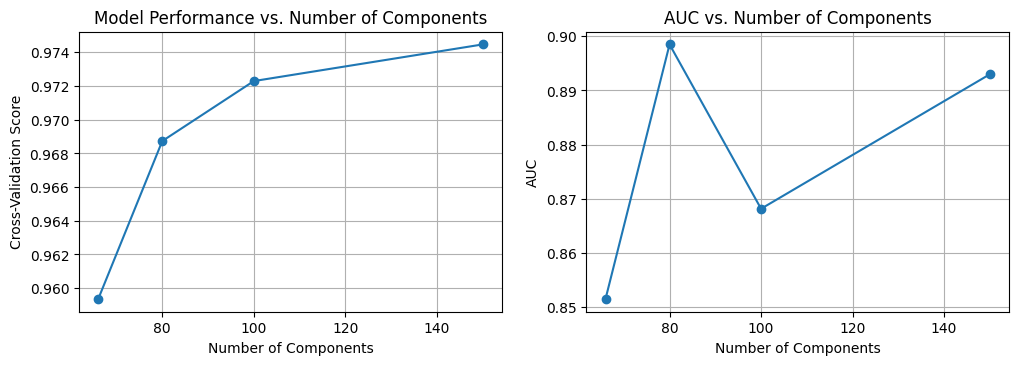

In [12]:
# Range for the number of PCA components
num_components_range = [66, 80, 100, 150]

scores = []
confusion_matrices = []
aucs = []
classification_reports = []

# Defining X and y
X = df_reduced.drop(['TLJYWBE', 'TLJYWBE_results'], axis=1).values
y = df_reduced['TLJYWBE_results'].values

for num_components in num_components_range:
    # Pipeline with imputation, scaling, PCA, resampling, and model
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=num_components)),
        ('downsampling', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
        ('upsampling', SMOTE(random_state=42)),
        ('classifier', xgb.XGBClassifier(
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        ))
    ])

    # Cross-validation
    y_pred = cross_val_predict(pipeline, X, y, cv=5, method='predict')
    y_pred_proba = cross_val_predict(pipeline, X, y, cv=5, method='predict_proba')[:, 1]

    # Evaluate performance
    score = cross_val_score(pipeline, X, y, cv=5).mean()
    confusion_mtx = confusion_matrix(y, y_pred)
    auc = roc_auc_score(y, y_pred_proba)
    report = classification_report(y, y_pred, output_dict=True)

    scores.append(score)
    confusion_matrices.append(confusion_mtx)
    aucs.append(auc)
    classification_reports.append(report)

# Plot of cross-validation scores
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(num_components_range, scores, marker='o')
plt.title('Model Performance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validation Score')
plt.grid()

# Plot of AUC scores
plt.subplot(2, 2, 2)
plt.plot(num_components_range, aucs, marker='o')
plt.title('AUC vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('AUC')
plt.grid()

plt.show()

for num_components, confusion_mtx, auc, report in zip(num_components_range, confusion_matrices, aucs, classification_reports):
    print(f'Number of Components: {num_components}')
    print('Confusion Matrix:')
    print(confusion_mtx)
    print(f'AUC: {auc:.4f}')
    print('Classification Report:')
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"Class {label}: Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1-score']:.4f}")

In [14]:
# Print the detailed classification reports
for num_components, confusion_mtx, auc, report in zip(num_components_range, confusion_matrices, aucs, classification_reports):
    print(f'Number of Components: {num_components}')
    print('Confusion Matrix:')
    print(confusion_mtx)
    print(f'AUC: {auc:.4f}')
    print('Classification Report:')
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"Class {label}: Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1-score']:.4f}")

Number of Components: 66
Confusion Matrix:
[[    16     19]
 [ 10083 273707]]
AUC: 0.8515
Classification Report:
Class 0: Precision: 0.0016, Recall: 0.4571, F1 Score: 0.0032
Class 1: Precision: 0.9999, Recall: 0.9645, F1 Score: 0.9819
Class macro avg: Precision: 0.5008, Recall: 0.7108, F1 Score: 0.4925
Class weighted avg: Precision: 0.9998, Recall: 0.9644, F1 Score: 0.9818
Number of Components: 80
Confusion Matrix:
[[    16     19]
 [  8771 275019]]
AUC: 0.8985
Classification Report:
Class 0: Precision: 0.0018, Recall: 0.4571, F1 Score: 0.0036
Class 1: Precision: 0.9999, Recall: 0.9691, F1 Score: 0.9843
Class macro avg: Precision: 0.5009, Recall: 0.7131, F1 Score: 0.4939
Class weighted avg: Precision: 0.9998, Recall: 0.9690, F1 Score: 0.9841
Number of Components: 100
Confusion Matrix:
[[    14     21]
 [  8022 275768]]
AUC: 0.8682
Classification Report:
Class 0: Precision: 0.0017, Recall: 0.4000, F1 Score: 0.0035
Class 1: Precision: 0.9999, Recall: 0.9717, F1 Score: 0.9856
Class macro 

###**Strategy Comparison: PCA vs. SelectKBest & Resampling**

After finding optimal num_components for PCA, I will evaluating different strategies to determine the most effective approach (PCA vs. SelectKBest, with or without resampling).

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report


# Strategies
strategies = {}

# Strategy 1: PCA(150) + Resampling
strategies['PCA(150) + Resampling'] = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',  StandardScaler()),
    ('pca', PCA(n_components=150)),
    # ('downsampling', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
    ('upsampling', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
])

# Strategy 2: PCA(150) without Resampling
strategies['PCA(150) without Resampling'] = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',  StandardScaler()),
    ('pca', PCA(n_components=150)),
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
])

# Strategy 3: Feature Selection + Resampling
strategies['Feature Selection + Resampling'] = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('feature_selection', SelectKBest(score_func=f_classif, k=100)),  # Adjust k as needed
    # ('downsampling', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
    ('upsampling', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
])

# Strategy 4: Feature Selection without Resampling
strategies['Feature Selection without Resampling'] = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('feature_selection', SelectKBest(score_func=f_classif, k=100)),  # Adjust k as needed
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
])

# Custom cross-validation loop due to need to re-calc scale_pos_weight for each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = {}

for strategy_name, pipeline in strategies.items():
    print(f"Evaluating {strategy_name}...")

    aucs, reports, mean_scores = [], [], []
    cumulative_report = None

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[test_idx]
        y_train, y_val = y[train_idx], y[test_idx]

        # Recalculate scale_pos_weight for this fold
        class_counts = pd.Series(y_train).value_counts()
        scale_pos_weight = class_counts[0] / class_counts[1]

        # Update the classifier's scale_pos_weight (will affect mostly when there is no re-sampling)
        if 'scale_pos_weight' in pipeline.named_steps['classifier'].get_params():
            pipeline.named_steps['classifier'].set_params(scale_pos_weight=scale_pos_weight)

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

        aucs.append(roc_auc_score(y_val, y_pred_proba))
        mean_scores.append(pipeline.score(X_val, y_val))

        report = classification_report(y_val, y_pred, output_dict=True)

        # Accumulate the classification report
        if cumulative_report is None:
            cumulative_report = report
        else:
            for key in report.keys():
                if isinstance(report[key], dict):  # Only iterate over metrics, not overall average values
                    for metric in report[key]:
                        cumulative_report[key][metric] += report[key][metric]

    # Average the accumulated report metrics
    for key in cumulative_report.keys():
        if isinstance(cumulative_report[key], dict):  # Only average the metrics, not overall average values
            for metric in cumulative_report[key]:
                cumulative_report[key][metric] /= cv.get_n_splits()

    scores[strategy_name] = {
        'score': np.mean(mean_scores),
        'auc': np.mean(aucs),
        'report': cumulative_report
    }


# Display results
for strategy_name, metrics in scores.items():
    print(f"\nStrategy: {strategy_name}")
    print(f"Mean CV Score: {metrics['score']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")
    print("Classification Report for Class 0:")
    print(f"Precision: {metrics['report']['0']['precision']:.4f}")
    print(f"Recall: {metrics['report']['0']['recall']:.4f}")
    print(f"F1 Score: {metrics['report']['0']['f1-score']:.4f}")
    print('Classification Report:')
    for label, metric in metrics['report'].items():
        if isinstance(metric, dict):
            print(f"Class {label}: Precision: {metric['precision']:.4f}, Recall: {metric['recall']:.4f}, F1 Score: {metric['f1-score']:.4f}")


Evaluating PCA(150) + Resampling...
Evaluating PCA(150) without Resampling...
Evaluating Feature Selection + Resampling...
Evaluating Feature Selection without Resampling...

Strategy: PCA(150) + Resampling
Mean CV Score: 0.9276
AUC: 0.8969
Classification Report for Class 0:
Precision: 0.0010
Recall: 0.5714
F1 Score: 0.0020
Classification Report:
Class 0: Precision: 0.0010, Recall: 0.5714, F1 Score: 0.0020
Class 1: Precision: 0.9999, Recall: 0.9277, F1 Score: 0.9624
Class macro avg: Precision: 0.5005, Recall: 0.7495, F1 Score: 0.4822
Class weighted avg: Precision: 0.9998, Recall: 0.9276, F1 Score: 0.9623

Strategy: PCA(150) without Resampling
Mean CV Score: 0.9915
AUC: 0.8692
Classification Report for Class 0:
Precision: 0.0036
Recall: 0.2571
F1 Score: 0.0071
Classification Report:
Class 0: Precision: 0.0036, Recall: 0.2571, F1 Score: 0.0071
Class 1: Precision: 0.9999, Recall: 0.9916, F1 Score: 0.9957
Class macro avg: Precision: 0.5018, Recall: 0.6243, F1 Score: 0.5014
Class weighted a

##**Finalize and Train Chosen Model**

**Best Overall:** *Feature Selection without Resampling:* This strategy achieves the best balance among AUC, CV score, and performance across both classes, making it the most well-rounded option.

**Class 0 Performance:** If the recall for class 0 is of utmost importance, the *Feature Selection + Resampling* strategy is worth considering further despite its low precision for class 0. Given that false negatives (e.g., failing a test incorrectly) are considered more detrimental than false positives (e.g., not passing a good test), I will choose Feature Selection + Resampling as the final model. Class 1's metrics are high and consistent across all strategies, so the decision is primarily based on improving class 0 performance.


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

# Prepare data
X = df_reduced.drop(['TLJYWBE', 'TLJYWBE_results'], axis=1).values
y = df_reduced['TLJYWBE_results'].values

# Pipeline with Feature Selection + Resampling
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif, k=100)),
    ('upsampling', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# Custom cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
y_true, y_pred = [], []
y_true_proba = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Recalculate scale_pos_weight for this fold
    class_counts = pd.Series(y_train).value_counts()
    scale_pos_weight = class_counts[0] / class_counts[1]

    pipeline.named_steps['classifier'].set_params(scale_pos_weight=scale_pos_weight)

    pipeline.fit(X_train, y_train)
    y_test_pred = pipeline.predict(X_test)
    y_test_proba = pipeline.predict_proba(X_test)[:, 1]

    cv_scores.append(pipeline.score(X_test, y_test))
    y_true.extend(y_test)
    y_pred.extend(y_test_pred)
    y_true_proba.extend(y_test_proba)

# Convert lists to numpy arrays for evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true_proba = np.array(y_true_proba)

# Evaluate the model
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores):.4f}")

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
print(f'ROC AUC: {roc_auc_score(y_true, y_true_proba):.4f}')

Cross-Validation Scores: [0.8851852504360388, 0.8802699036310142, 0.8844805412166805, 0.8850090731311993, 0.8837405965363542]
Mean CV Score: 0.8837
Classification Report:
              precision    recall  f1-score   support

           0       0.00      1.00      0.00        19
           1       1.00      0.88      0.94    283786

    accuracy                           0.88    283805
   macro avg       0.50      0.94      0.47    283805
weighted avg       1.00      0.88      0.94    283805

Confusion Matrix:
[[    19      0]
 [ 32996 250790]]
Precision: 1.0000
Recall: 0.8837
F1 Score: 0.9383
ROC AUC: 0.9426
